# Yolo V5 with PyTorch batch

**YOLO - an acronym for 'You only look once'** - is an **object detection algorithm** that divides images into a grid system. Each cell in the grid is responsible for detecting objects within itself.

YOLO is one of the most famous object detection algorithms due to its speed and accuracy.**YOLOv5** has multiple varieties of pre-trained models as we can see below. <br>

The difference between them is the trade-off between **the size of the model**, **inference time** and **precision**. The lightweight model version **YOLOv5n6 is just a few MB** with **1.9M parameters** but not very accurate (mAP = 34). On the other side of the spectrum, we have **YOLOv5x6 whose size is much bigger** but is the most accurate version of its family (**140.7M parameters mAP > 54**).

https://github.com/ultralytics/yolov5/releases

<img src="img/yolo5chart.png" width=800>

<img src="img/yolo5.jpg">

## 1. Settings

In [1]:
#!pip install --upgrade torchvision
#!pip install --upgrade pillow

In [2]:
import torch
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt 
import os.path
from os import path
import datetime
import sys

In [3]:
print(torch.__version__)

1.10.1+cu102


In [4]:
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [5]:
def datetimeformat(ts):
    return datetime.datetime.fromtimestamp(ts)

In [6]:
def dirfiles(DIRNAME):
    for item in os.scandir(DIRNAME):
         print(datetimeformat(item.stat().st_atime), item.stat().st_size, item.name)

In [7]:
def createdir(dirname):
    if path.os.path.isdir(dirname) :
        print("Directory:", dirname, "exists")
    else:
        print("Creating directory:", dirname)
        os.mkdir(dirname)
        print("Done")

In [8]:
!nvidia-smi

Thu Feb  3 13:38:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   52C    P0    58W / 149W |    948MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |                    0 |
| N/A   

## 2. Download Yolo pretrained model

In [9]:
yolomodelversion = 'yolov5m6'

#or
#yolomodelversion = 'yolov5n6'
#yolomodelversion = 'yolov5s6'
#yolomodelversion = 'yolov5m6'
#yolomodelversion = 'yolov5x6'

In [10]:
YOLODIR = 'yolo'

In [11]:
os.chdir(YOLODIR)
model = torch.hub.load('ultralytics/yolov5', yolomodelversion, pretrained=True) # We can use yolov5n, yolov5s...
os.chdir('..')

Using cache found in /home/azureuser/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-2-1 torch 1.10.1+cu102 CUDA:0 (Tesla K80, 11441MiB)



  0%|          | 0.00/68.7M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 378 layers, 35704908 parameters, 0 gradients
Adding AutoShape... 


In [12]:
dirfiles(YOLODIR)

2022-02-03 13:37:21.098256 154206589 yolov5l6.pt
2022-02-03 13:39:11.127213 71993357 yolov5m6.pt


## 3. Function

In [13]:
color_lime = (0, 255, 0)
color_cyan = (255, 255, 0)
color_red = (0, 0, 255)
color_orange = (0, 140, 255)
color_purple = (128, 0, 128)

In [14]:
RESULTS_DIR = 'batch'
createdir(RESULTS_DIR)

Creating directory: batch
Done


In [15]:
def callingyolov5(image, conf, iou):
    # settings
    model.conf = conf  # confidence threshold (0-1)
    model.iou = iou # NMS IoU threshold (0-1)
    model.classes = [0, 1, 2, 3, 4, 5, 6]
    
    # model
    print("\033[1;31;34m")
    print("-" * 30, "Analyzing", image, "-" * 30, '\n')
    
    yolocv = model(image)
    yolocv.print()
    yoloarray = yolocv.xyxy[0].cpu().detach().numpy()
    
    i = 1
    print("\033[1;31;34mNumber of detected objects =", len(yoloarray), '\n')
    
    img = cv2.imread(image)

    while i <= len(yoloarray):
        x1 = int(yoloarray[i-1][0])
        y1 = int(yoloarray[i-1][1])
        x2 = int(yoloarray[i-1][2])
        y2 = int(yoloarray[i-1][3])
        confidence = yoloarray[i-1][4]
        tag = yoloarray[i-1][5]
    
        if tag == 0:
            tagname = 'person'
        if tag == 1:
            tagname = 'bicycle'
        if tag == 2:
            tagname = 'car'
        if tag == 3:
            tagname = 'motorbike'
        if tag == 5:
            tagname = 'bus' 
        if tag == 7:
            tagname = 'truck' 
                
        xcenter = int((x1 + x2 ) / 2)
        ycenter = int((y1 + y2 ) / 2)
        msg = tagname
        
        print(i, "\tObject:", tagname, 
              "\tConfidence =", round(confidence, 4), 
              "\tBbox: [", x1, '\t', y1, '\t', x2, '\t', y2, ']')
        
        rectsize = 2
        fontsize = 0.7
        thickness = 1
        font = cv2.FONT_HERSHEY_TRIPLEX  
    
        if tag == 0:
            cv2.rectangle(img, (x1, y1), (x2, y2), color_cyan, rectsize)
            cv2.putText(img, msg, (xcenter, ycenter), font, fontsize, color_cyan, thickness, cv2.LINE_AA)
        if tag == 1:
            cv2.rectangle(img, (x1, y1), (x2, y2), color_cyan, rectsize)
            cv2.putText(img, msg, (xcenter, ycenter), font, fontsize, color_cyan, thickness, cv2.LINE_AA)
        if tag == 2:
            cv2.rectangle(img, (x1, y1), (x2, y2), color_lime, rectsize)
            cv2.putText(img, msg, (xcenter, ycenter), font, fontsize, color_lime, thickness, cv2.LINE_AA)
        if tag == 3:
            cv2.rectangle(img, (x1, y1), (x2, y2), color_orange, rectsize)
            cv2.putText(img, msg, (xcenter, ycenter), font, fontsize, color_orange, thickness, cv2.LINE_AA) 
        if tag == 5:
            cv2.rectangle(img, (x1, y1), (x2, y2), color_red, rectsize)
            cv2.putText(img, msg, (xcenter, ycenter), font, fontsize, color_red, thickness, cv2.LINE_AA)  
        if tag == 7:
            cv2.rectangle(img, (x1, y1), (x2, y2), color_purple, rectsize)
            cv2.putText(img, msg, (xcenter, ycenter), font, fontsize, color_purple, thickness, cv2.LINE_AA)  
        
        i +=1
        del x1, y1, x2, y2
    
    df = yolocv.pandas().xyxy[0]
    print("\033[1;31;91m")
    print("Results:")
    print(df['name'].value_counts(sort=True))
    print()
    
    # Saving images
    filename = os.path.basename(image)
    outputfilename = RESULTS_DIR + '/processed_' + filename
    cv2.imwrite(outputfilename, img)


## Testing on a single image

In [16]:
callingyolov5("images/image2.jpg", 0.4, 0.45)

image 1/1: 600x800 2 persons, 10 cars, 2 buss



------------------------------ Analyzing images/image2.jpg ------------------------------ 



Speed: 117.1ms pre-process, 77.0ms inference, 3.9ms NMS per image at shape (1, 3, 512, 640)


Number of detected objects = 14 

1 	Object: car 	Confidence = 0.9072 	Bbox: [ 118 	 471 	 200 	 511 ]
2 	Object: car 	Confidence = 0.8995 	Bbox: [ 358 	 462 	 417 	 491 ]
3 	Object: bus 	Confidence = 0.894 	Bbox: [ 302 	 427 	 417 	 486 ]
4 	Object: car 	Confidence = 0.8825 	Bbox: [ 449 	 477 	 537 	 522 ]
5 	Object: car 	Confidence = 0.7093 	Bbox: [ 615 	 455 	 644 	 478 ]
6 	Object: car 	Confidence = 0.7082 	Bbox: [ 530 	 457 	 560 	 482 ]
7 	Object: car 	Confidence = 0.6723 	Bbox: [ 427 	 452 	 477 	 485 ]
8 	Object: car 	Confidence = 0.6567 	Bbox: [ 783 	 454 	 799 	 477 ]
9 	Object: person 	Confidence = 0.6156 	Bbox: [ 230 	 457 	 241 	 482 ]
10 	Object: car 	Confidence = 0.6046 	Bbox: [ 569 	 452 	 612 	 482 ]
11 	Object: bus 	Confidence = 0.6016 	Bbox: [ 474 	 428 	 553 	 478 ]
12 	Object: car 	Confidence = 0.5178 	Bbox: [ 706 	 452 	 728 	 469 ]
13 	Object: car 	Confidence = 0.4891 	Bbox: [ 644 	 452 	 685 	 478 ]
14 	Object: person 	Confidence = 0.4667 	Bbox: [ 214 	 455 	 22

## Testing on a full images directory

In [20]:
MYDIR = 'images'

In [21]:
dirfiles(MYDIR)

2022-02-02 12:53:35.324728 0 .ipynb_checkpoints
2022-02-03 09:51:37.641468 376113 image1.jpg
2022-02-03 09:51:31.437018 303976 image2.jpg
2022-02-03 09:51:27.963006 442514 image3.jpg
2022-02-03 09:51:36.398179 250326 image4.jpg
2022-02-02 15:51:48.190284 0 test


In [22]:
## Batch
images = [file for file in os.listdir(MYDIR) if file.endswith(('jpeg', 'jpg'))]
for image in images:
    imagefile = "images/" + str(image)
    callingyolov5(imagefile, 0.3, 0.45)


------------------------------ Analyzing images/image1.jpg ------------------------------ 



image 1/1: 600x800 5 persons, 6 cars, 1 motorcycle, 1 bus
Speed: 198.0ms pre-process, 74.7ms inference, 2.2ms NMS per image at shape (1, 3, 512, 640)


Number of detected objects = 13 

1 	Object: car 	Confidence = 0.9263 	Bbox: [ 0 	 397 	 138 	 458 ]
2 	Object: motorbike 	Confidence = 0.8296 	Bbox: [ 189 	 419 	 273 	 507 ]
3 	Object: car 	Confidence = 0.8212 	Bbox: [ 370 	 383 	 421 	 412 ]
4 	Object: person 	Confidence = 0.7843 	Bbox: [ 213 	 389 	 259 	 480 ]
5 	Object: car 	Confidence = 0.6679 	Bbox: [ 414 	 378 	 449 	 408 ]
6 	Object: person 	Confidence = 0.6658 	Bbox: [ 681 	 374 	 697 	 416 ]
7 	Object: car 	Confidence = 0.6012 	Bbox: [ 513 	 374 	 537 	 393 ]
8 	Object: person 	Confidence = 0.5835 	Bbox: [ 719 	 364 	 735 	 414 ]
9 	Object: person 	Confidence = 0.5414 	Bbox: [ 700 	 377 	 715 	 415 ]
10 	Object: person 	Confidence = 0.533 	Bbox: [ 342 	 378 	 355 	 411 ]
11 	Object: bus 	Confidence = 0.452 	Bbox: [ 542 	 357 	 581 	 391 ]
12 	Object: car 	Confidence = 0.4412 	Bbox: [ 649 	 368 	 668 	 382 ]
13 	Object: car 	Confidence = 0.4021 	Bbox: [ 449 	 381 	 476 	 398 ]

Results:
car           6
person        5
bus   

image 1/1: 600x800 3 persons, 11 cars, 3 buss
Speed: 57.5ms pre-process, 74.8ms inference, 2.0ms NMS per image at shape (1, 3, 512, 640)



------------------------------ Analyzing images/image2.jpg ------------------------------ 

Number of detected objects = 17 

1 	Object: car 	Confidence = 0.9072 	Bbox: [ 118 	 471 	 200 	 511 ]
2 	Object: car 	Confidence = 0.8995 	Bbox: [ 358 	 462 	 417 	 491 ]
3 	Object: bus 	Confidence = 0.894 	Bbox: [ 302 	 427 	 417 	 486 ]
4 	Object: car 	Confidence = 0.8825 	Bbox: [ 449 	 477 	 537 	 522 ]
5 	Object: car 	Confidence = 0.7093 	Bbox: [ 615 	 455 	 644 	 478 ]
6 	Object: car 	Confidence = 0.7082 	Bbox: [ 530 	 457 	 560 	 482 ]
7 	Object: car 	Confidence = 0.6723 	Bbox: [ 427 	 452 	 477 	 485 ]
8 	Object: car 	Confidence = 0.6567 	Bbox: [ 783 	 454 	 799 	 477 ]
9 	Object: person 	Confidence = 0.6156 	Bbox: [ 230 	 457 	 241 	 482 ]
10 	Object: car 	Confidence = 0.6046 	Bbox: [ 569 	 452 	 612 	 482 ]
11 	Object: bus 	Confidence = 0.6016 	Bbox: [ 474 	 428 	 553 	 478 ]
12 	Object: car 	Confidence = 0.5178 	Bbox: [ 706 	 452 	 728 	 469 ]
13 	Object: car 	Confidence = 0.4891 	Bb

image 1/1: 600x934 8 persons, 7 cars, 4 buss
Speed: 94.6ms pre-process, 71.6ms inference, 2.0ms NMS per image at shape (1, 3, 448, 640)



------------------------------ Analyzing images/image3.jpg ------------------------------ 

Number of detected objects = 19 

1 	Object: bus 	Confidence = 0.9438 	Bbox: [ 465 	 207 	 824 	 484 ]
2 	Object: bus 	Confidence = 0.9195 	Bbox: [ 164 	 102 	 334 	 217 ]
3 	Object: bus 	Confidence = 0.8734 	Bbox: [ 0 	 95 	 141 	 202 ]
4 	Object: car 	Confidence = 0.8557 	Bbox: [ 86 	 167 	 170 	 215 ]
5 	Object: car 	Confidence = 0.8522 	Bbox: [ 0 	 311 	 121 	 385 ]
6 	Object: person 	Confidence = 0.8429 	Bbox: [ 841 	 407 	 872 	 483 ]
7 	Object: car 	Confidence = 0.7884 	Bbox: [ 276 	 297 	 406 	 355 ]
8 	Object: car 	Confidence = 0.7829 	Bbox: [ 206 	 231 	 294 	 290 ]
9 	Object: bus 	Confidence = 0.7648 	Bbox: [ 321 	 217 	 466 	 324 ]
10 	Object: person 	Confidence = 0.7356 	Bbox: [ 873 	 420 	 905 	 499 ]
11 	Object: person 	Confidence = 0.7317 	Bbox: [ 430 	 309 	 454 	 364 ]
12 	Object: car 	Confidence = 0.7272 	Bbox: [ 364 	 122 	 419 	 162 ]
13 	Object: person 	Confidence = 0.7053

image 1/1: 600x800 13 persons, 9 cars, 1 motorcycle, 1 bus
Speed: 67.9ms pre-process, 74.8ms inference, 2.1ms NMS per image at shape (1, 3, 512, 640)



------------------------------ Analyzing images/image4.jpg ------------------------------ 

Number of detected objects = 24 

1 	Object: car 	Confidence = 0.8451 	Bbox: [ 46 	 405 	 104 	 454 ]
2 	Object: person 	Confidence = 0.8221 	Bbox: [ 577 	 390 	 612 	 490 ]
3 	Object: person 	Confidence = 0.82 	Bbox: [ 608 	 397 	 660 	 488 ]
4 	Object: person 	Confidence = 0.7917 	Bbox: [ 314 	 402 	 358 	 486 ]
5 	Object: person 	Confidence = 0.7542 	Bbox: [ 266 	 394 	 306 	 487 ]
6 	Object: motorbike 	Confidence = 0.7455 	Bbox: [ 702 	 473 	 743 	 535 ]
7 	Object: person 	Confidence = 0.7412 	Bbox: [ 443 	 390 	 492 	 490 ]
8 	Object: car 	Confidence = 0.7377 	Bbox: [ 106 	 404 	 155 	 456 ]
9 	Object: car 	Confidence = 0.7357 	Bbox: [ 241 	 393 	 276 	 434 ]
10 	Object: car 	Confidence = 0.7078 	Bbox: [ 406 	 398 	 447 	 439 ]
11 	Object: car 	Confidence = 0.6874 	Bbox: [ 560 	 389 	 588 	 413 ]
12 	Object: car 	Confidence = 0.6201 	Bbox: [ 135 	 406 	 183 	 470 ]
13 	Object: bus 	Confide

In [23]:
dirfiles(RESULTS_DIR)

2022-02-03 13:40:16.329861 208155 processed_image1.jpg
2022-02-03 13:40:16.853561 149175 processed_image2.jpg
2022-02-03 13:40:17.332286 262152 processed_image3.jpg
2022-02-03 13:40:17.832999 145865 processed_image4.jpg


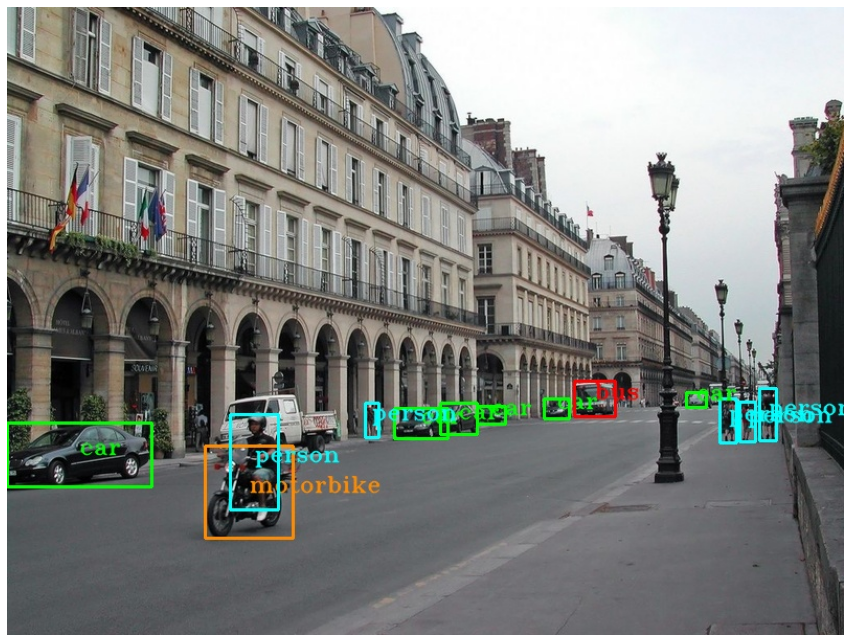

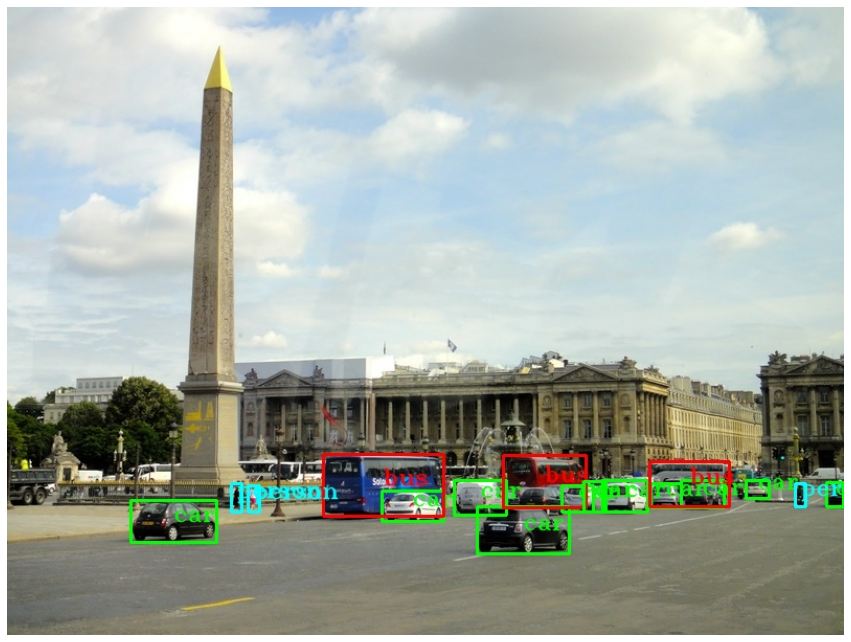

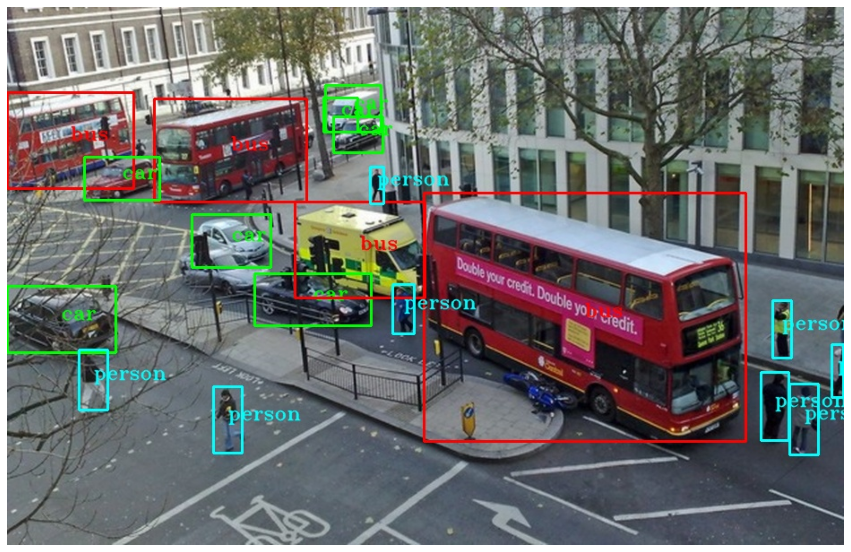

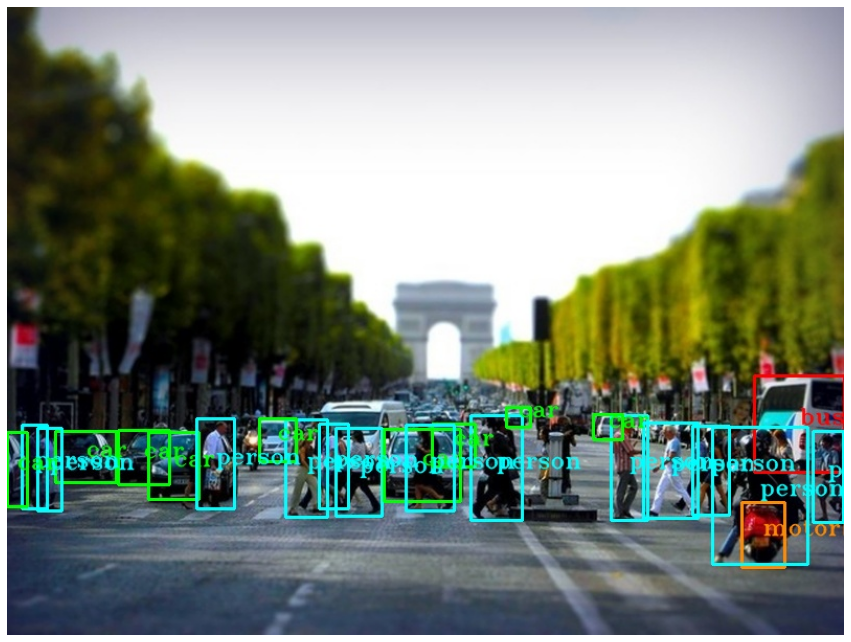

In [24]:
from IPython.display import Image
%matplotlib inline

images = [file for file in os.listdir(RESULTS_DIR) if file.endswith(('jpeg', 'jpg'))]
for image in images:
    filename = RESULTS_DIR + '/' + image
    img = cv2.imread(filename)
    plt.figure(figsize=(15,15)) 
    plt.axis('off')
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)